In [ ]:
"""
This notebook installs the necessary packages for the Brain Tumour Segmentation project.
It installs the following packages:
- split-folders: A tool to split folders into training, validation, and test sets.
- tabulate: A library to create formatted tables.
"""

! pip install -q split-folders
! pip install -q tabulate

In [ ]:
"""
This script removes the specified directories if they exist.
"""

import shutil

shutil.rmtree('/kaggle/working/BrainTS/', ignore_errors=True)
shutil.rmtree('/kaggle/working/BestModels', ignore_errors=True)
shutil.rmtree('/kaggle/working/logs', ignore_errors=True)

In [ ]:
"""
This script removes the specified zip files if they exist.
"""

import os

try:
    os.remove('/kaggle/working/BestModels.zip')
    os.remove('/kaggle/working/BrainTS.zip')
    os.remove('/kaggle/working/logs.zip')

except FileNotFoundError:
    print(f"No zip files found!")
    pass

No zip files found!


In [ ]:
"""
This script imports the necessary libraries and modules for the Brain Tumour Segmentation project.
"""

import os
import random
import numpy as np
import pandas as pd
import glob
import nibabel as nib
from tqdm import tqdm
import kagglehub
import shutil
import json
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.utils import to_categorical

import tensorflow as tf
import tensorflow.keras.backend as K
import keras.backend as k
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Concatenate, Dropout, Conv2DTranspose, AveragePooling2D
from tensorflow.keras import Model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

from tabulate import tabulate
import splitfolders

import warnings
warnings.filterwarnings('ignore')

In [ ]:
"""
This script sets up the configuration for the Brain Tumour Segmentation project.
It includes the following configurations:

- BATCH_SIZE: Batch size for training
- EPOCHS: Number of epochs for training
- DECODER_STAGES: Number of decoder stages
- current_timestamp: Current timestamp in the format YYYYMMDD_HHMMSS
- plot_sample: Boolean to indicate whether to plot sample images
- RATES: List of rates for some process
- LR: Learning rate
- includeT1: Boolean to indicate whether to include T1 images
- shuffle: Boolean to indicate whether to shuffle the data
- datasetInputTrain: Path to the training dataset
- datasetInputTest: Path to the test dataset
- exceptionFolder: Path to the exception folder
- trainPaths: Path to the training data
- testPaths: Path to the test data
- rename355SegSrc: Source path for renaming a specific segmentation file
- rename355SegTgt: Target path for renaming a specific segmentation file
- saveNPYimages: Path to save NPY images
- saveNPYmasks: Path to save NPY masks
- saveTestNPYimages: Path to save test NPY images
- splitInputFolder: Path to the input folder for splitting data
- splitOutputFolder: Path to the output folder for splitting data
- train_img_dir: Directory for training images
- train_mask_dir: Directory for training masks
- val_img_dir: Directory for validation images
- val_mask_dir: Directory for validation masks
- test_img_dir: Directory for test images
- test_mask_dir: Directory for test masks
- loadTrainPath: Path to load the training dataset
- loadTestPath: Path to load the test dataset
- saveBestModelPath: Path to save the best model
- threshold: Threshold value for some process
- SMOOTH: Smoothing value for some process
"""

utc_offset = timezone(timedelta(hours=5, minutes=30))
current_timestamp = datetime.now(utc_offset).strftime("%Y%m%d_%H%M%S")

workingDirectory = os.getcwd()+ '/'


def get_working_directory():
    return workingDirectory


config = {
    "BATCH_SIZE": 16,
    "EPOCHS": 100,
    "DECODER_STAGES": 5,
    "current_timestamp": current_timestamp,
    "plot_sample": False,
    "RATES": [6, 12, 18],
    "LR": 1e-4,
    "includeT1": False,
    "shuffle": True,

    "datasetInputTrain": "/kaggle/input/brats2020/BraTS20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/",
    "datasetInputTest": "/kaggle/input/brats2020/BraTS20/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/",
    "exceptionFolder": "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355",

    "trainPaths": f"{workingDirectory}BraTS20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/",
    "testPaths": f"{workingDirectory}BraTS20/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData",

    "rename355SegSrc": f"{workingDirectory}BraTS20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii",
    "rename355SegTgt": f"{workingDirectory}BraTS20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii",

    "saveNPYimages": f"{workingDirectory}BrainTS/train/input3ch/images/",
    "saveNPYmasks": f"{workingDirectory}BrainTS/train/input3ch/masks/",
    "saveTestNPYimages": f"{workingDirectory}BrainTS/test/input3ch/images/",

    "splitInputFolder": f"{workingDirectory}BrainTS/train/input3ch/",
    "splitOutputFolder": f"{workingDirectory}BrainTS/training/",

    "train_img_dir": f"{workingDirectory}BrainTS/training/train/images/",
    "train_mask_dir": f"{workingDirectory}BrainTS/training/train/masks/",

    "val_img_dir": f"{workingDirectory}BrainTS/training/val/images/",
    "val_mask_dir": f"{workingDirectory}BrainTS/training/val/masks/",

    "test_img_dir": f"{workingDirectory}BrainTS/training/test/images/",
    "test_mask_dir": f"{workingDirectory}BrainTS/training/test/masks/",

    # SET TRAIN AND TEST DATASET PATH
    "loadTrainPath": f"{workingDirectory}BraTS20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData",
    "loadTestPath": f"{workingDirectory}/BraTS20/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData",

    "saveBestModelPath": f"{workingDirectory}BestModels/",

    "threshold": 0.25,
    "SMOOTH": 1e-6

}

In [ ]:
class BrainTumourDataset:
    """
    A class used to represent the Brain Tumour Dataset and its processing methods.
    """

    def __init__(self):
        """
        Initialize the BrainTumourDataset class.
        """
        super().__init__()
        self.workingDirectory = get_working_directory()
        self.scaler = MinMaxScaler()

    def download_dataset(self):
        """
        Download the BraTS20 dataset if it does not exist in the respective environment.
        """
        chk_dataset = False
        if 'kaggle' in self.workingDirectory:
            chk_dataset = "BraTS2020_TrainingData" not in os.listdir(
                "/kaggle/input/brats2020/BraTS20") and "BraTS2020_ValidationData" not in os.listdir("/kaggle/input/brats2020/BraTS20")
        else:
            chk_dataset = 'BraTS' in os.listdir()

        if chk_dataset:
            try:
                print("Dataset not found. Downloading BraTS20 Dataset...")
                datasetPath = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")
                print(f"Path to dataset: {datasetPath}")

                # Moving dataset to working directory
                dst = os.path.join(self.workingDirectory, 'dataset')
                print("Moving dataset to working directory")
                shutil.move(datasetPath, dst)

                print("Renaming dataset to BraTS")
                if "/content/" in self.workingDirectory:
                    os.rename(src=os.path.join(self.workingDirectory, 'dataset'),
                              dst=os.path.join(self.workingDirectory, 'BraTS20'))
                else:
                    os.rename(src=os.path.join(self.workingDirectory, 'dataset/1'),
                              dst=os.path.join(self.workingDirectory, 'BraTS20'))

                print("Renaming incorrect filename...")
                os.rename(config['rename355SegSrc'], config['rename355SegTgt'])

            except Exception as e:
                raise RuntimeError(f"Dataset download failed: {e}")

        else:
            print("Dataset BraTS20 already existing!")

    def _process_image(self, imagePath):
        """
        Load and normalize an image.

        :param imagePath: Path to the image file.
        :return: Normalized image.
        """
        image = nib.load(imagePath).get_fdata()
        image = self.scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
        return image

    def _process_mask(self, maskPath):
        """
        Load and process a mask.

        :param maskPath: Path to the mask file.
        :return: Processed mask.
        """
        mask = nib.load(maskPath).get_fdata()
        mask[mask == 4] = 3
        return mask

    @staticmethod
    def _plot_samples(image_slice, mask_slice, slice_idx, load_type):
        """
        Plot sample images and mask for visualization.

        :param image_slice: Slice of the image.
        :param mask_slice: Slice of the mask.
        :param slice_idx: Index of the slice.
        :param load_type: Type of data loading (train/test).
        """
        print(image_slice.shape)
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 4, 1)
        plt.imshow(image_slice[:, :, 0])
        plt.title('FLAIR')
        plt.subplot(2, 4, 2)
        plt.imshow(image_slice[:, :, 1])
        plt.title('T1CE')
        plt.subplot(2, 4, 3)
        plt.imshow(image_slice[:, :, 2])
        plt.title('T2')

        if config['includeT1']:
            plt.subplot(2, 4, 4)
            plt.imshow(image_slice[:, :, 3])
            plt.title('T1')

        if load_type == 'train':
            for i in range(mask_slice.shape[-1]):
                plt.subplot(2, 4, 5 + i)
                plt.imshow(mask_slice[:, :, i])
                plt.title(f"MASK_{i}")
        plt.show()

    def _save_slices(self, image, mask, idx, load_type, plot_sample):
        """
        Save image/mask as .npy files.

        :param image: Image data.
        :param mask: Mask data.
        :param idx: Index of the image.
        :param load_type: Type of data loading (train/test).
        :param plot_sample: Boolean to indicate whether to plot sample images.
        """
        channels = image.shape[2]
        lowerBound = int((channels / 2) - (image.shape[2] / 4))
        upperBound = int((channels / 2) + (image.shape[2] / 4))
        mask_slice = np.empty(0, dtype=np.uint8)
        cnt = 0

        for slice_idx in range(lowerBound, upperBound, 16):
            if load_type == 'train':
                if np.unique(mask[:, :, slice_idx]).any() == 0:
                    continue

                mask_slice = np.expand_dims(mask[:, :, slice_idx], axis=2)
                mask_slice = to_categorical(mask_slice, num_classes=4)

            image_slice = image[:, :, slice_idx]

            if plot_sample:
                self._plot_samples(image_slice, mask_slice, slice_idx, load_type)
                plot_sample = False

            if load_type == 'train':
                os.makedirs(config['saveNPYimages'], exist_ok=True)
                os.makedirs(config["saveNPYmasks"], exist_ok=True)
                np.save(f"{config['saveNPYimages']}BraTS_image_{str(idx + 1).rjust(3, '0')}_{slice_idx}.npy", image_slice)
                np.save(f"{config['saveNPYmasks']}BraTS_mask_{str(idx + 1).rjust(3, '0')}_{slice_idx}.npy", mask_slice)

            else:
                os.makedirs(config['saveTestNPYimages'], exist_ok=True)
                np.save(f"{config['saveTestNPYimages']}BraTS_{str(idx + 1).rjust(3, '0')}_{cnt}.npy", image_slice)

            cnt += 1

    def load_data(self, path, load_type='train', plot_sample=False):
        """
        Load and preprocess dataset.

        :param path: Path to the dataset.
        :param load_type: Type of data loading (train/test).
        :param plot_sample: Boolean to indicate whether to plot sample images.
        """
        os.makedirs(os.path.join(self.workingDirectory, 'BrainTS/'), exist_ok=True)

        chk_train = "train" in os.listdir(os.path.join(self.workingDirectory, 'BrainTS/'))
        chk_test = "test" in os.listdir(os.path.join(self.workingDirectory, 'BrainTS/'))

        if chk_train and load_type == 'train':
            if plot_sample:
                imgPth = f"{config['train_img_dir']}{random.choice(os.listdir(config['train_img_dir']))}"
                print(imgPth)
                img = np.load(imgPth)
                print(img.shape)
                mskPth = imgPth.replace('image', 'mask')
                msk = np.load(mskPth)
                self._plot_samples(img, msk, 0, load_type)
            print(f"NPY {load_type.capitalize()} Dataset BraTS already exists and preprocessed!")

        elif chk_test and load_type == 'test':
            if plot_sample:
                imgPth = f"{config['train_img_dir']}{random.choice(os.listdir(config['train_img_dir']))}"
                img = np.load(imgPth)
                self._plot_samples(img, mask_slice=None, slice_idx=0, load_type=load_type)
            print(f"NPY {load_type.capitalize()} Dataset BraTS already exists and preprocessed!")

        else:
            flair_list = sorted(glob.glob(path + "/*/*flair.nii"))
            t1ce_list = sorted(glob.glob(path + "/*/*t1ce.nii"))
            t2_list = sorted(glob.glob(path + "/*/*t2.nii"))
            if config['includeT1']:
                t1_list = sorted(glob.glob(path + "/*/*t1.nii"))

            for img in tqdm(range(len(flair_list))):
                # FLAIR
                temp_img_flair = self._process_image(flair_list[img])

                # T1
                if config['includeT1']:
                    temp_img_t1 = self._process_image(t1_list[img])

                # T1CE
                temp_img_t1ce = self._process_image(t1ce_list[img])

                # T2
                temp_img_t2 = self._process_image(t2_list[img])

                if config['includeT1']:
                    # Ensure that all input images have the same shape
                    assert temp_img_flair.shape == temp_img_t1.shape == temp_img_t1ce.shape == temp_img_t2.shape, "All input images must have the same shape."
                    # Combine images into 4D array
                    temp_img = np.stack([temp_img_flair, temp_img_t1ce, temp_img_t2, temp_img_t1], axis=-1)
                else:
                    # Ensure that all input images have the same shape
                    assert temp_img_flair.shape == temp_img_t1ce.shape == temp_img_t2.shape, "All input images must have the same shape."
                    # Combine images into 3D array
                    temp_img = np.stack([temp_img_flair, temp_img_t1ce, temp_img_t2], axis=3)

                temp_img = temp_img[24:216, 24:216, 13:141]

                temp_msk = None
                if load_type == 'train':
                    mask_list = sorted(glob.glob(path + "/*/*seg.nii"))
                    temp_msk = self._process_mask(mask_list[img])
                    temp_msk = temp_msk[24:216, 24:216, 13:141]

                self._save_slices(temp_img, temp_msk, img, load_type, plot_sample)

    def split_dataset(self, train_ratio=0.8, test_ratio=0.0, test=False):
        """
        Split dataset into train, test, and validation folders.

        :param train_ratio: Ratio of training data.
        :param test_ratio: Ratio of test data.
        :param test: Boolean to indicate whether to include test data.
        """
        os.makedirs(config['splitOutputFolder'], exist_ok=True)
        chk_trn = 'train' in os.listdir(f"{self.workingDirectory}BrainTS/training")
        chk_val = 'val' in os.listdir(f"{self.workingDirectory}BrainTS/training")

        if not (chk_trn and chk_val):
            assert not (test and test_ratio == 0), "Enter test_ratio > 0 when test=True"
            seed = random.randint(0, 100)
            print(f'Test: {test}')
            if test:
                val_ratio = 1.0 - train_ratio - test_ratio
                splitfolders.ratio(input=config['splitInputFolder'], output=config['splitOutputFolder'],
                                   ratio=(train_ratio, val_ratio, test_ratio), move=False, seed=seed)
            else:
                val_ratio = 1.0 - train_ratio
                splitfolders.ratio(input=config['splitInputFolder'], output=config['splitOutputFolder'],
                                   ratio=(train_ratio, val_ratio), move=False, seed=seed)
        else:
            print(f"Train-Test Split is done!")

In [ ]:
class DataLoader:
    """
    A class used to load and generate batches of images and masks for training.
    """

    def __init__(self, img_dir, msk_dir):
        """
        Initialize the DataLoader class.

        :param img_dir: Directory containing the images.
        :param msk_dir: Directory containing the masks.
        """
        super().__init__()
        self.img_dir = img_dir
        self.msk_dir = msk_dir
        self.batch_size = config['BATCH_SIZE']
        self.workingDirectory = get_working_directory()

    @staticmethod
    def _load_images(folder, fileList):
        """
        Load images/masks from directory based on file names.

        :param folder: Directory containing the files.
        :param fileList: List of file names to load.
        :return: Array of loaded images/masks.
        """
        images = []
        for file in fileList:
            if file.endswith('.npy'):
                filePath = os.path.join(folder, file)
                image = np.load(filePath)
                images.append(image)

        return np.array(images)

    def data_generator(self):
        """
        Generator function to yield images and masks in batches.

        :return: Yields batches of images and masks.
        """
        imageList = sorted(os.listdir(self.img_dir))
        maskList = sorted(os.listdir(self.msk_dir))

        total_samples = len(imageList)
        while True:
            batchStart = 0
            batchEnd = self.batch_size

            while batchStart < total_samples:
                limit = min(batchEnd, total_samples)

                X = self._load_images(self.img_dir, imageList[batchStart:limit])
                Y = self._load_images(self.msk_dir, maskList[batchStart:limit])

                yield X, Y

                batchStart += self.batch_size
                batchEnd += self.batch_size

In [ ]:
SMOOTH = config['SMOOTH']

def iou_metric(y_true, y_pred, smooth=SMOOTH):
    """
    Calculate the Intersection over Union (IoU) metric.

    :param y_true: Ground truth labels.
    :param y_pred: Predicted labels.
    :param smooth: Smoothing factor to avoid division by zero.
    :return: Average IoU across all classes.
    """
    y_true_f = tf.reshape(y_true, (-1, y_true.shape[-1]))
    y_pred_f = tf.reshape(y_pred, (-1, y_pred.shape[-1]))

    y_true_f = tf.cast(y_true_f, tf.float32)
    y_pred_f = tf.cast(y_pred_f, tf.float32)

    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    union = tf.reduce_sum(y_true_f, axis=0) + tf.reduce_sum(y_pred_f, axis=0)

    iou = (intersection + smooth) / (union + smooth)

    return tf.reduce_mean(iou)

def dice_coef(y_true, y_pred, smooth=SMOOTH):
    """
    Calculate the Dice coefficient.

    :param y_true: Ground truth labels.
    :param y_pred: Predicted labels.
    :param smooth: Smoothing factor to avoid division by zero.
    :return: Average Dice coefficient across all classes.
    """
    class_num = y_true.shape[-1]    # Number of classes in the prediction
    total_dice = 0.0    # Initialize total Dice coefficient

    for i in range(class_num):
        # Flatten the tensors for each class
        y_true_f = tf.keras.layers.Flatten()(y_true[..., i])
        y_pred_f = tf.keras.layers.Flatten()(y_pred[..., i])

        # Cast tensors to float32
        y_true_f = tf.cast(y_true_f, tf.float32)
        y_pred_f = tf.cast(y_pred_f, tf.float32)

        # Compute intersection and union
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)

        # Dice coefficient for current class
        dice = (2. * intersection + smooth) / (union + smooth)
        
        # Accumulate the Dice score
        total_dice += dice
    
    # Return average Dice coefficient across all classes
    return total_dice / class_num

def dice_coef_necrotic(y_true, y_pred, epsilon=SMOOTH):
    """
    Calculate the Dice coefficient for necrotic tumor.

    :param y_true: Ground truth labels.
    :param y_pred: Predicted labels.
    :param epsilon: Smoothing factor to avoid division by zero.
    :return: Dice coefficient for necrotic tumor.
    """
    y_true_f = K.cast(y_true, 'float32')
    y_pred_f = K.cast(y_pred, 'float32')

    intersection = K.sum(y_true_f[:, :, 1] * y_pred_f[:, :, 1])
    return (2. * intersection + epsilon) / (K.sum(y_true_f[:, :, 1]) + K.sum(y_pred_f[:, :, 1]) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=SMOOTH):
    """
    Calculate the Dice coefficient for edema tumor.

    :param y_true: Ground truth labels.
    :param y_pred: Predicted labels.
    :param epsilon: Smoothing factor to avoid division by zero.
    :return: Dice coefficient for edema tumor.
    """
    y_true_f = K.cast(y_true, 'float32')
    y_pred_f = K.cast(y_pred, 'float32')

    intersection = K.sum(y_true_f[:, :, 2] * y_pred_f[:, :, 2])
    return (2. * intersection + epsilon) / (K.sum(y_true_f[:, :, 2]) + K.sum(y_pred_f[:, :, 2]) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=SMOOTH):
    """
    Calculate the Dice coefficient for enhancing tumor.

    :param y_true: Ground truth labels.
    :param y_pred: Predicted labels.
    :param epsilon: Smoothing factor to avoid division by zero.
    :return: Dice coefficient for enhancing tumor.
    """
    y_true_f = K.cast(y_true, 'float32')
    y_pred_f = K.cast(y_pred, 'float32')

    intersection = K.sum(y_true_f[:, :, 3] * y_pred_f[:, :, 3])
    return (2. * intersection + epsilon) / (K.sum(y_true_f[:, :, 3]) + K.sum(y_pred_f[:, :, 3]) + epsilon)

def dice_coef_no_tumour(y_true, y_pred, epsilon=SMOOTH):
    """
    Calculate the Dice coefficient for no tumor.

    :param y_true: Ground truth labels.
    :param y_pred: Predicted labels.
    :param epsilon: Smoothing factor to avoid division by zero.
    :return: Dice coefficient for no tumor.
    """
    y_true_f = K.cast(y_true, 'float32')
    y_pred_f = K.cast(y_pred, 'float32')

    intersection = K.sum(y_true_f[:, :, 0] * y_pred_f[:, :, 0])
    return (2. * intersection + epsilon) / (K.sum(y_true_f[:, :, 0]) + K.sum(y_pred_f[:, :, 0]) + epsilon)

def precision(y_true, y_pred):
    """
    Calculate the precision metric.

    :param y_true: Ground truth labels.
    :param y_pred: Predicted labels.
    :return: Precision metric.
    """
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')

    true_positives = K.sum(K.round(K.clip(y_true_f * y_pred_f, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred_f, 0, 1)))

    return true_positives / (predicted_positives + K.epsilon())

def sensitivity(y_true, y_pred):
    """
    Calculate the sensitivity (recall) metric.

    :param y_true: Ground truth labels.
    :param y_pred: Predicted labels.
    :return: Sensitivity metric.
    """
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')

    true_positives = K.sum(K.round(K.clip(y_true_f * y_pred_f, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true_f, 0, 1)))

    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    """
    Calculate the specificity metric.

    :param y_true: Ground truth labels.
    :param y_pred: Predicted labels.
    :return: Specificity metric.
    """
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')

    true_negatives = K.sum(K.round(K.clip((1 - y_true_f) * (1 - y_pred_f), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true_f, 0, 1)))

    return true_negatives / (possible_negatives + K.epsilon())

def total_loss(y_true, y_pred, num_classes):
    """
    Calculate the total loss, which is a combination of categorical/binary cross-entropy, Dice loss, and IoU loss.

    :param y_true: Ground truth labels.
    :param y_pred: Predicted labels.
    :param num_classes: Number of classes in the prediction.
    :return: Total loss.
    """
    if num_classes == 1:
        ce_loss = categorical_crossentropy(y_true, y_pred)
    else:
        ce_loss = binary_crossentropy(y_true, y_pred)

    dice_loss = 1.0 - dice_coef(y_true, y_pred)
    iou_loss = 1.0 - iou_metric(y_true, y_pred)

    TOTAL_LOSS = ce_loss + dice_loss + iou_loss

    return TOTAL_LOSS

In [ ]:
class ModelTrainer:
    """
    A class used to train and evaluate the model for brain tumour segmentation.
    """

    def __init__(self, model):
        """
        Initialize the ModelTrainer class.

        :param model: The model to be trained and evaluated.
        """
        super().__init__()
        self.model = model
        self.LR = config['LR']
        self.compile_model()

    def compile_model(self):
        """
        Compile the model with an Adam optimizer and appropriate loss function.
        """
        def loss_fn(y_true, y_pred):
            return total_loss(y_true, y_pred, self.model.num_classes)

        metrics = [
            'accuracy',
            iou_metric,
            dice_coef,
            precision,
            sensitivity,
            specificity,
            dice_coef_necrotic,
            dice_coef_edema,
            dice_coef_enhancing,
            dice_coef_no_tumour
        ]

        self.model.model.compile(
            optimizer=Adam(learning_rate=self.LR),
            loss=loss_fn,
            metrics=metrics
        )

    def train(self, train_gen, val_gen, epochs, steps_per_epoch, validation_steps, model_save_path):
        """
        Train the model using the provided data generators.

        :param train_gen: Training data generator.
        :param val_gen: Validation data generator.
        :param epochs: Number of epochs to train the model.
        :param steps_per_epoch: Number of steps per epoch.
        :param validation_steps: Number of validation steps.
        :param model_save_path: Path to save the best model.
        :return: Training history.
        """
        log_file_path = model_save_path.replace(".keras", "_logs.csv")

        # Check if log file exists else create
        if not os.path.exists(log_file_path):
            os.makedirs(config["saveBestModelPath"], exist_ok=True)
            df = pd.DataFrame()  
            df.to_csv(log_file_path)
            
        callbacks = [
            ModelCheckpoint(model_save_path, monitor='val_loss', mode='min', save_best_only=True, verbose=1),
            CSVLogger(log_file_path, append=True)
            # EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
        ]

        tensorboard_callback = tf.keras.callbacks.TensorBoard(f"{workingDirectory}logs/{model_save_path.split('/')[-1].split('__')[1]}")

        history = self.model.model.fit(
            train_gen,
            epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            validation_data=val_gen,
            validation_steps=validation_steps,
            callbacks=[callbacks, tensorboard_callback]
        )

        # Save history to a text file
        history_file_path = model_save_path.replace(".keras", "_history.txt")
        with open(history_file_path, 'w') as f:
            json.dump(history.history, f, indent=4)  # Save as JSON for better readability

        return history

    def evaluate(self, data_gen, steps):
        """
        Evaluate the model on the test data generator.

        :param data_gen: Test data generator.
        :param steps: Number of steps for evaluation.
        :return: Evaluation results.
        """
        return self.model.model.evaluate(data_gen, steps=steps)

    def predict(self, data, verbose=1):
        """
        Predict the output for the given input data.

        :param data: Input data for prediction.
        :param verbose: Verbosity mode.
        :return: Predicted output.
        """
        return self.model.model.predict(data, verbose=verbose)

In [ ]:
class ResNet50:
    """
    A class used to build and manage a ResNet50-based model for brain tumour segmentation.
    """

    def __init__(self, input_shape, num_classes=1):
        """
        Initialize the ResNet50 class.

        :param input_shape: Shape of the input images.
        :param num_classes: Number of output classes.
        """
        super().__init__()
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_resnet50()

    @staticmethod
    def _conv_block(x, num_filters):
        """
        Create a convolutional block with Conv2D, LeakyReLU, and Dropout layers.

        :param x: Input tensor.
        :param num_filters: Number of filters for the Conv2D layers.
        :return: Output tensor.
        """
        x = Conv2D(num_filters, 3, padding="same", kernel_initializer="he_normal")(x)
        x = LeakyReLU(negative_slope=0.0001)(x)
        x = Dropout(0.2)(x)
        x = Conv2D(num_filters, 3, padding="same", kernel_initializer="he_normal")(x)
        x = LeakyReLU(negative_slope=0.0001)(x)
        return x

    @staticmethod
    def _encoder_block(self, x, num_filters):
        """
        Create an encoder block with convolutional and max pooling layers.

        :param x: Input tensor.
        :param num_filters: Number of filters for the Conv2D layers.
        :return: Tuple of output tensor and pooled tensor.
        """
        x = self._conv_block(x, num_filters)
        p = MaxPooling2D(pool_size=(2, 2))(x)
        return x, p

    @staticmethod
    def _decoder_block(self, x, skip_cxn, num_filters, kernel_size=(2, 2), strides=2):
        """
        Create a decoder block with Conv2DTranspose and concatenation layers.

        :param x: Input tensor.
        :param skip_cxn: Skip connection tensor.
        :param num_filters: Number of filters for the Conv2D layers.
        :param kernel_size: Kernel size for the Conv2DTranspose layer.
        :param strides: Strides for the Conv2DTranspose layer.
        :return: Output tensor.
        """
        x = Conv2DTranspose(num_filters, kernel_size=kernel_size, strides=strides, padding="same")(x)
        if skip_cxn is not None:
            x = Concatenate()([x, skip_cxn])
        x = self._conv_block(x, num_filters)
        return x

    def build_resnet50(self):
        """
        Build the ResNet50 model with custom modifications for brain tumour segmentation.

        :return: Compiled ResNet50 model.
        """
        ip = Input(shape=self.input_shape)

        # CONTRACTING PATH: Load ResNet50V2 and modify first layer to accept 4 channels
        base_encoder = ResNet50V2(include_top=False, weights='imagenet', input_tensor=ip)
        base_encoder.trainable = False  # Freeze the base encoder layers

        # Modify the first layer of ResNet50V2 to accept 4 channels (instead of 3 channels)
        # base_encoder.layers[0] = Conv2D(64, (7, 7), padding="same", strides=(2, 2), use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.05), input_shape=self.input_shape)

        skip_connections = [
            base_encoder.get_layer("conv1_conv").output,
            base_encoder.get_layer("conv2_block3_out").output,
            base_encoder.get_layer("conv3_block4_out").output,
            base_encoder.get_layer("conv4_block6_out").output
        ]

        # BOTTLENECK
        b = base_encoder.output

        # EXPANDING PATH
        d1 = self._decoder_block(self, x=b, skip_cxn=skip_connections[3], num_filters=1024, kernel_size=(1, 1), strides=1)
        d2 = self._decoder_block(self, x=d1, skip_cxn=skip_connections[2], num_filters=512, kernel_size=(2, 2), strides=2)
        d3 = self._decoder_block(self, x=d2, skip_cxn=skip_connections[1], num_filters=256, kernel_size=(2, 2), strides=2)
        d4 = self._decoder_block(self, x=d3, skip_cxn=skip_connections[0], num_filters=64, kernel_size=(4, 4), strides=4)
        d5 = self._decoder_block(self, x=d4, skip_cxn=None, num_filters=32, kernel_size=(2, 2), strides=2)

        if self.num_classes == 1:
            op = Conv2D(self.num_classes, 1, padding="same", activation="sigmoid")(d5)
        else:
            op = Conv2D(self.num_classes, 1, padding="same", activation="softmax")(d5)

        k.clear_session()
        model = Model(inputs=ip, outputs=op, name="ResNet50V2")
        return model

    def summary(self):
        """
        Print the summary of the model.

        :return: Model summary.
        """
        return self.model.summary()

    def get_model_name(self):
        """
        Get the name of the model.

        :return: Model name.
        """
        return self.model.name


class ResNet50_ASPP(ResNet50):
    """
    A class used to build and manage a ResNet50-based model with Atrous Spatial Pyramid Pooling (ASPP) for brain tumour segmentation.
    """

    def __init__(self, input_shape, num_classes=1):
        """
        Initialize the ResNet50_ASPP class.

        :param input_shape: Shape of the input images.
        :param num_classes: Number of output classes.
        """
        super().__init__(input_shape, num_classes)
        self.model = self.build_resnet50_aspp()

    @staticmethod
    def _aspp_block(x, num_filters, rates):
        """
        Atrous Spatial Pyramid Pooling (ASPP) block.

        :param x: Input tensor.
        :param num_filters: Number of filters for the Conv2D layers.
        :param rates: Dilation rates for the atrous convolutions.
        :return: Output tensor.
        """
        # 1x1 Convolution
        conv_1x1 = Conv2D(num_filters, 1, activation="relu", padding="same")(x)

        # Atrous Convolutions with different dilation rates
        conv_3x3_1 = Conv2D(num_filters, 3, dilation_rate=rates[0], activation="relu", padding="same")(x)
        conv_3x3_2 = Conv2D(num_filters, 3, dilation_rate=rates[1], activation="relu", padding="same")(x)
        conv_3x3_3 = Conv2D(num_filters, 3, dilation_rate=rates[2], activation="relu", padding="same")(x)

        # Image Pooling
        image_pooling = AveragePooling2D(pool_size=(x.shape[1], x.shape[2]))(x)
        image_pooling = Conv2D(num_filters, 1, activation="relu", padding="same")(image_pooling)
        image_pooling = UpSampling2D(size=(x.shape[1], x.shape[2]), interpolation='bilinear')(image_pooling)

        # Concatenate all outputs
        x = Concatenate()([conv_1x1, conv_3x3_1, conv_3x3_2, conv_3x3_3, image_pooling])

        # 1x1 Convolution to reduce channels
        x = Conv2D(num_filters, 1, activation="relu", padding="same")(x)
        return x

    def build_resnet50_aspp(self):
        """
        Build the ResNet50 model with ASPP for brain tumour segmentation.

        :return: Compiled ResNet50_ASPP model.
        """
        ip = Input(shape=self.input_shape)

        # CONTRACTING PATH: Load ResNet50V2 and modify first layer to accept 4 channels
        base_encoder = ResNet50V2(include_top=False, weights='imagenet', input_tensor=ip)
        base_encoder.trainable = False  # Freeze the base encoder layers

        # Modify the first layer of ResNet50V2 to accept 4 channels (instead of 3 channels)
        # base_encoder.layers[0] = Conv2D(64, (7, 7), padding="same", strides=(2, 2), use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.05), input_shape=self.input_shape)(ip)

        skip_connections = [
            base_encoder.get_layer("conv1_conv").output,
            base_encoder.get_layer("conv2_block3_out").output,
            base_encoder.get_layer("conv3_block4_out").output,
            base_encoder.get_layer("conv4_block6_out").output
        ]

        # ASPP for skip connections
        aspp_skip_connections = [
            self._aspp_block(skip_connections[i], skip_connections[i].shape[3], rates=config['RATES'])
            for i in range(len(skip_connections))
        ]

        # BOTTLENECK
        b = base_encoder.output

        # EXPANDING PATH
        d1 = self._decoder_block(self, x=b, skip_cxn=aspp_skip_connections[3], num_filters=1024, kernel_size=(1, 1), strides=1)
        d2 = self._decoder_block(self, x=d1, skip_cxn=aspp_skip_connections[2], num_filters=512, kernel_size=(2, 2), strides=2)
        d3 = self._decoder_block(self, x=d2, skip_cxn=aspp_skip_connections[1], num_filters=256, kernel_size=(2, 2), strides=2)
        d4 = self._decoder_block(self, x=d3, skip_cxn=aspp_skip_connections[0], num_filters=64, kernel_size=(4, 4), strides=4)
        d5 = self._decoder_block(self, x=d4, skip_cxn=None, num_filters=32, kernel_size=(2, 2), strides=2)

        if self.num_classes == 1:
            op = Conv2D(self.num_classes, 1, padding="same", activation="sigmoid")(d5)
        else:
            op = Conv2D(self.num_classes, 1, padding="same", activation="softmax")(d5)

        k.clear_session()
        model = Model(inputs=ip, outputs=op, name='ResNet50V2_ASPP')
        return model

    def summary(self, line_length=None, positions=None, print_fn=None):
        """
        Print the summary of the model.

        :return: Model summary.
        """
        return self.model.summary(line_length = line_length, positions = positions, print_fn = print_fn)

    def get_model_name(self):
        """
        Get the name of the model.

        :return: Model name.
        """
        return self.model.name

In [ ]:
"""
This script sets up the working directory, downloads the BraTS20 dataset, and processes the training and testing data.
It also splits the dataset into training, validation, and test sets.
"""

print(f"Working Directory: {get_working_directory()}")

dataProcessor = BrainTumourDataset()
print(f"Downloading the BraTS20 dataset...")

dataProcessor.download_dataset()

print(f"Load Training Data")

if os.path.exists('BrainTS/train/input3ch/images/'):
    if config['includeT1'] == True and np.load('BrainTS/train/input3ch/images/' + random.choice(os.listdir('BrainTS/train/input3ch/images/'))).shape[-1] == 4:
        print(f"Include T1: {config['includeT1']} and channels: {np.load('BrainTS/train/input3ch/images/' + random.choice(os.listdir('BrainTS/train/input3ch/images/'))).shape[-1]}")
        pass
    elif config['includeT1'] == False and np.load('BrainTS/train/input3ch/images/' + random.choice(os.listdir('BrainTS/train/input3ch/images/'))).shape[-1] == 3:
        print(f"Include T1: {config['includeT1']} and channels: {np.load('BrainTS/train/input3ch/images/' + random.choice(os.listdir('BrainTS/train/input3ch/images/'))).shape[-1]}")
        pass
    else:
        try:
            print(f"Include T1: {config['includeT1']} and channels: {np.load('BrainTS/train/input3ch/images/' + random.choice(os.listdir('BrainTS/train/input3ch/images/'))).shape[-1]}")
            print(f"Removing the dir BrainTS and reloading")
            shutil.rmtree('BrainTS', ignore_errors=True)
        except:
            pass

dataProcessor.load_data(path=config['datasetInputTrain'], load_type='train', plot_sample=config['plot_sample'])

print(f"Load Testing Data")
dataProcessor.load_data(path=config['datasetInputTest'], load_type='test', plot_sample=config['plot_sample'])

print(f"Train Val Split Folders")
if config["shuffle"]:
    print("Shuffling Train-Val-Test Split")
    shutil.rmtree(f"{workingDirectory}/BrainTS/training", ignore_errors=True)
dataProcessor.split_dataset(train_ratio=0.7, test_ratio=0.15, test=True)

Working Directory: /kaggle/working/
Dataset BraTS20 already existing!
Load Training Data


100%|██████████| 369/369 [10:50<00:00,  1.76s/it]


Load Testing Data


100%|██████████| 125/125 [02:30<00:00,  1.21s/it]


Train Val Split Folders
Shuffling Train-Val-Test Split
Test: True


Copying files: 2216 files [00:07, 300.56 files/s]


In [ ]:
"""
This script sets up the data loaders for training and validation data, and prints the shapes of the data batches.
"""

INPUT_SHAPE = (256, 256, 3)
NUM_CLASSES = 4

trainDataLoader = DataLoader(config['train_img_dir'], config['train_mask_dir'])
trainDataGen = trainDataLoader.data_generator()

for batch in trainDataGen:
    X, Y = batch
    INPUT_SHAPE = X.shape[1:]
    NUM_CLASSES = Y.shape[-1]
    print(f"Train Generator X:{X.shape}\tY:{Y.shape}")
    print(f"Train Generator X:{X.shape}\tY:{Y.shape[-1]}")
    break

valDataLoader = DataLoader(config['val_img_dir'], config['val_mask_dir'])
valDataGen = valDataLoader.data_generator()

for batch in valDataGen:
    X, Y = batch
    print(f"Validation Generator X:{X.shape}\tY:{Y.shape}")
    break

Train Generator X:(16, 192, 192, 3)	Y:(16, 192, 192, 4)
Train Generator X:(16, 192, 192, 3)	Y:4
Validation Generator X:(16, 192, 192, 3)	Y:(16, 192, 192, 4)


In [ ]:
"""
This script calculates and prints the number of steps per epoch for training and validation data.
"""

steps_per_epoch = len(sorted(os.listdir(config['train_img_dir']))) // config['BATCH_SIZE']
val_steps_per_epoch = len(sorted(os.listdir(config['val_img_dir']))) // config['BATCH_SIZE']

print(f"steps_per_epoch: {steps_per_epoch}")
print(f"val_steps_per_epoch: {val_steps_per_epoch}")

steps_per_epoch: 48
val_steps_per_epoch: 10


In [ ]:
"""
This script initializes the ResNet50_ASPP model for brain tumour segmentation and prints the model name.
"""

resnet_aspp = ResNet50_ASPP(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)
resnet_aspp_name = resnet_aspp.get_model_name()
print(f"ResNet Name: {resnet_aspp_name}")
# resnet_aspp.summary()

ResNet Name: ResNet50V2_ASPP


In [ ]:
%%time
"""
This script initializes the ModelTrainer class with the ResNet50_ASPP model and trains the model using the training and validation data generators.
"""

ResNetAsppModelTrain = ModelTrainer(model=resnet_aspp)
ResNetAsppModelTrain.train(
    train_gen=trainDataGen,
    val_gen=valDataGen,
    epochs=config['EPOCHS'],
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    model_save_path=f"{config['saveBestModelPath']}{resnet_aspp_name}__{config['current_timestamp']}.keras"
)

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.6282 - dice_coef: 0.1429 - dice_coef_edema: 0.3272 - dice_coef_enhancing: 0.3177 - dice_coef_necrotic: 0.3065 - dice_coef_no_tumour: 0.2886 - iou_metric: 0.0715 - loss: 2.4204 - precision: 0.2826 - sensitivity: 0.1722 - specificity: 0.9961
Epoch 1: val_loss improved from inf to 1.72173, saving model to /kaggle/working/BestModels/ResNet50V2_ASPP__20250314_001448.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 66s 814ms/step - accuracy: 0.6321 - dice_coef: 0.1438 - dice_coef_edema: 0.3313 - dice_coef_enhancing: 0.3216 - dice_coef_necrotic: 0.3100 - dice_coef_no_tumour: 0.2911 - iou_metric: 0.0719 - loss: 2.4163 - precision: 0.2895 - sensitivity: 0.1787 - specificity: 0.9960 - val_accuracy: 0.9466 - val_dice_coef: 0.2680 - val_dice_coef_edema: 0.9934 - val_dice_coef_enhancing: 0.9964 - val_dice_coef_necrotic: 0.9915 - val_dice_coef_no_tumour: 0.8852 - val_iou_metric: 0.1340 - val_loss: 1.7217 - val_precision: 0.9475 - val_sensitivity: 0.

In [ ]:
"""
This script evaluates the trained ResNet50_ASPP model on the validation data and prints the evaluation metrics in a tabulated format.
"""

res = ResNetAsppModelTrain.evaluate(data_gen=valDataGen, steps=val_steps_per_epoch)

headers = ["METRIC", "VALUE"]
data = [
    ["LOSS", res[0]],
    ["ACCURACY", res[1]],
    ["IOU_METRIC", res[2]],
    ["DICE_COEF", res[3]],
    ["PRECISION", res[4]],
    ["SENSITIVITY", res[5]],
    ["SPECIFICITY", res[6]],
    ["DICE_COEF_EDEMA", res[7]],
    ["DICE_COEF_ENHANCING", res[8]],
    ["DICE_COEF_NECROTIC", res[9]],
    ["DICE_COEF_NO_TUMOUR", res[10]],
]

print(tabulate(data, headers=headers, tablefmt="grid"))

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.9830 - dice_coef: 0.7618 - dice_coef_edema: 1.0000 - dice_coef_enhancing: 1.0000 - dice_coef_necrotic: 1.0000 - dice_coef_no_tumour: 1.0000 - iou_metric: 0.3809 - loss: 0.8919 - precision: 0.9832 - sensitivity: 0.9830 - specificity: 0.9944
+---------------------+----------+
| METRIC              |    VALUE |
+=====================+==========+
| LOSS                | 0.910688 |
+---------------------+----------+
| ACCURACY            | 0.97941  |
+---------------------+----------+
| IOU_METRIC          | 0.377254 |
+---------------------+----------+
| DICE_COEF           | 0.754508 |
+---------------------+----------+
| PRECISION           | 0.979772 |
+---------------------+----------+
| SENSITIVITY         | 0.979542 |
+---------------------+----------+
| SPECIFICITY         | 0.993259 |
+---------------------+----------+
| DICE_COEF_EDEMA     | 1        |
+---------------------+----------+
| DICE_COEF_ENHANCING | 1        |
+----

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
IOU: 0.38138478994369507
DICE: 0.7627695798873901
DICE-TUMORE_CORE: 0.6523297429084778
DICE-EDEMA: 0.7627695798873901
DICE-GD_ENHANCING: 0.7627695798873901


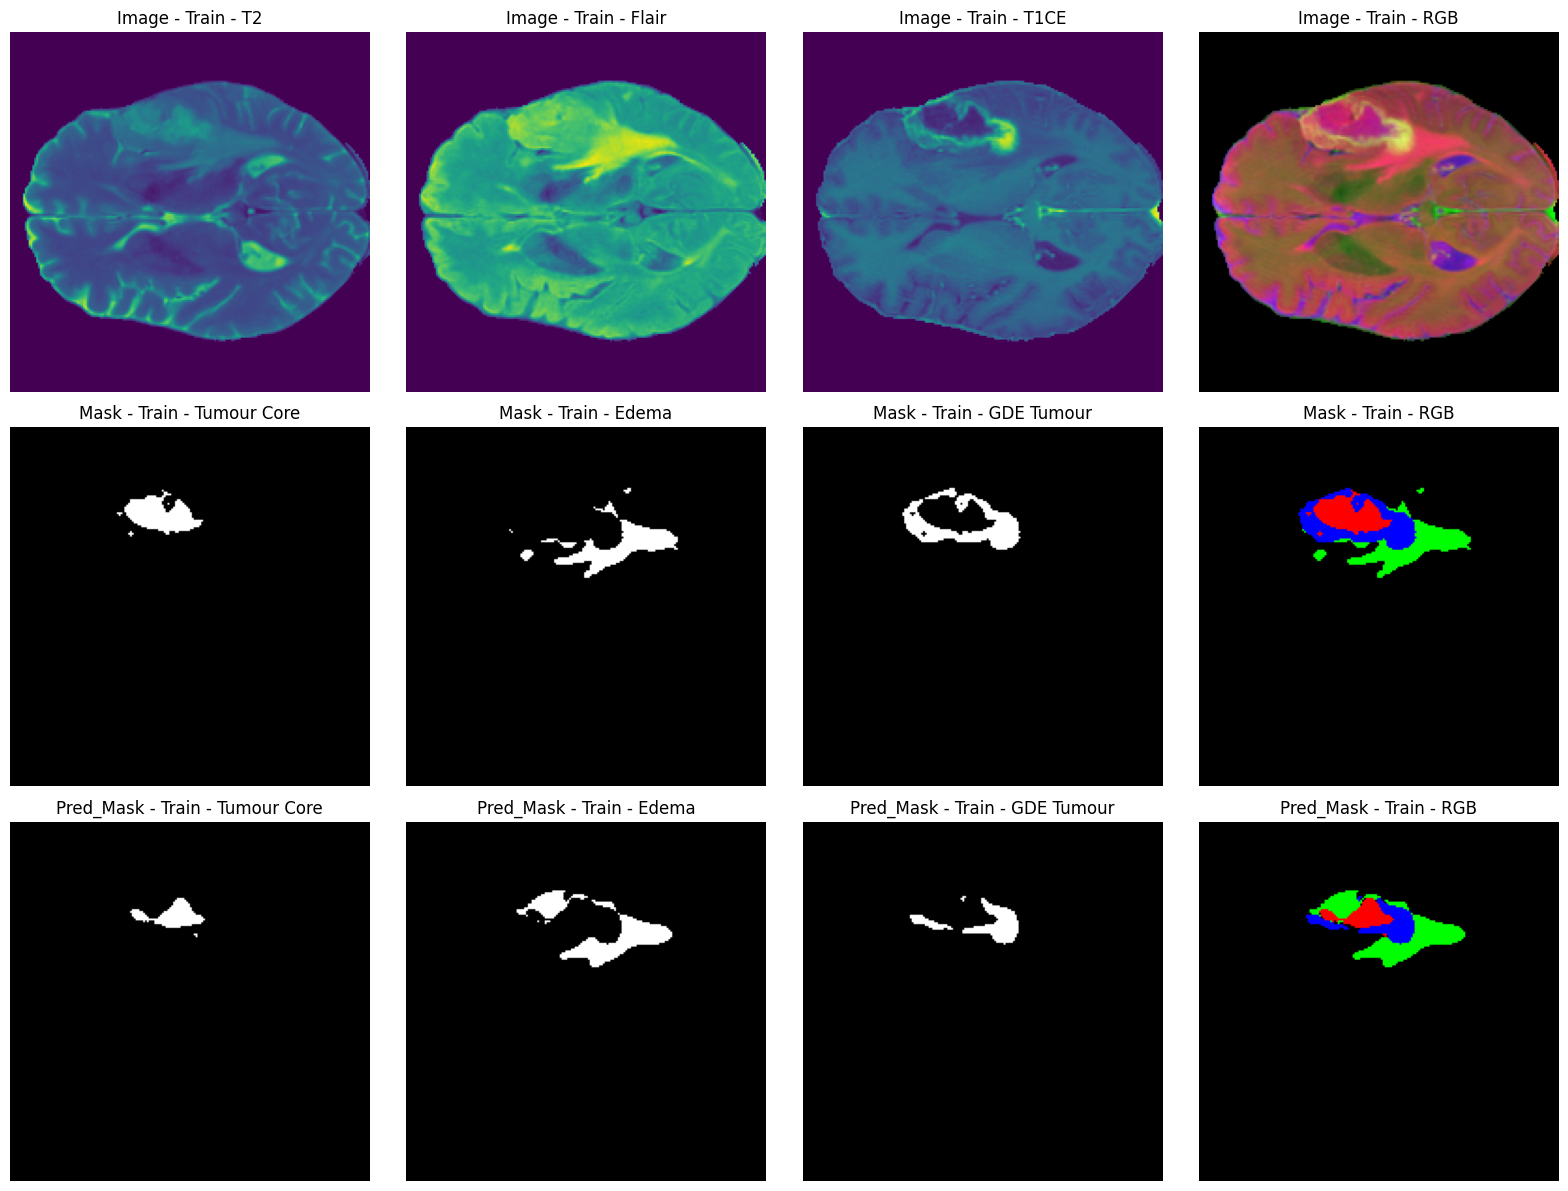

In [ ]:
"""
This script defines a function to make predictions using the trained model and visualize the results.
It also runs a prediction on a random test image.
"""

def prediction(model, imagePath, maskPath, imageName):
    """
    Make predictions using the trained model and visualize the results.

    :param model: Trained model for prediction.
    :param imagePath: Path to the directory containing the images.
    :param maskPath: Path to the directory containing the masks.
    :param imageName: Name of the image file to be predicted.
    """
    maskName = imageName.replace('image', 'mask')
    img = np.load(os.path.join(imagePath, imageName))
    msk = np.load(os.path.join(maskPath, maskName))
    pred_image = np.expand_dims(img, axis=0)
    pred = model.model.predict(pred_image)[0]

    pred[pred >= 0.5] = 1
    pred[pred < 0.5] = 0

    print(f'IOU: {iou_metric(tf.convert_to_tensor(msk), tf.convert_to_tensor(pred))}')
    print(f'DICE: {dice_coef(tf.convert_to_tensor(msk), tf.convert_to_tensor(pred))}')

    print(f'DICE-TUMORE_CORE: {dice_coef_necrotic(tf.convert_to_tensor(msk), tf.convert_to_tensor(pred))}')
    print(f'DICE-EDEMA: {dice_coef(tf.convert_to_tensor(msk), tf.convert_to_tensor(pred))}')
    print(f'DICE-GD_ENHANCING: {dice_coef(tf.convert_to_tensor(msk), tf.convert_to_tensor(pred))}')

    train_type = 'Train'

    # Create a figure and a 1x3 grid of subplots
    if train_type == 'Train':
        fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    else:
        fig, axes = plt.subplots(2, 4, figsize=(12, 6))

    # Display the image on each subplot
    axes[0][0].imshow(img[:, :, 2])
    axes[0][0].set_title(f"Image - {train_type} - T2")
    axes[0][0].axis('off')

    axes[0][1].imshow(img[:, :, 0])
    axes[0][1].set_title(f"Image - {train_type} - Flair")
    axes[0][1].axis('off')

    axes[0][2].imshow(img[:, :, 1])
    axes[0][2].set_title(f"Image - {train_type} - T1CE")
    axes[0][2].axis('off')

    if img.shape[2] == 4:
        axes[0][3].imshow(img[:, :, 3])
        axes[0][3].set_title(f"Image - {train_type} - T1")
        axes[0][3].axis('off')
    else:
        axes[0][3].imshow(img[:, :, :3])
        axes[0][3].set_title(f"Image - {train_type} - RGB")
        axes[0][3].axis('off')

    if train_type == 'Train':
        axes[1][0].imshow(msk[:, :, 1], cmap='gray')
        axes[1][0].set_title(f"Mask - {train_type} - Tumour Core")  # necrotic and non-enhancing tumor core (NCR/NET — label 1)
        axes[1][0].axis('off')

        axes[1][1].imshow(msk[:, :, 2], cmap='gray')
        axes[1][1].set_title(f"Mask - {train_type} - Edema")  # Peritumoral edema (ED — label 2)
        axes[1][1].axis('off')

        axes[1][2].imshow(msk[:, :, 3], cmap='gray')
        axes[1][2].set_title(f"Mask - {train_type} - GDE Tumour")  # Gadolinium-Enhancing Tumor (ET — label 4)
        axes[1][2].axis('off')

        axes[1][3].imshow(msk[:, :, 1:])
        axes[1][3].set_title(f"Mask - {train_type} - RGB")
        axes[1][3].axis('off')

        axes[2][0].imshow(pred[:, :, 1], cmap='gray')
        axes[2][0].set_title(f"Pred_Mask - {train_type} - Tumour Core")
        axes[2][0].axis('off')

        axes[2][1].imshow(pred[:, :, 2], cmap='gray')
        axes[2][1].set_title(f"Pred_Mask - {train_type} - Edema")
        axes[2][1].axis('off')

        axes[2][2].imshow(pred[:, :, 3], cmap='gray')
        axes[2][2].set_title(f"Pred_Mask - {train_type} - GDE Tumour")
        axes[2][2].axis('off')

        axes[2][3].imshow(pred[:, :, 1:])
        axes[2][3].set_title(f"Pred_Mask - {train_type} - RGB")
        axes[2][3].axis('off')

    plt.tight_layout()

testImgList = os.listdir(config['test_img_dir'])
prediction(resnet_aspp, config['test_img_dir'], config['test_mask_dir'], random.choice(testImgList))

In [ ]:
"""
This script defines a function to evaluate the trained model on training, validation, and test datasets.
It calculates various metrics and stores them in a list.
"""

METRICS = []

def evaluation_metrics(path, type):
    """
    Evaluate the trained model on the given dataset and calculate various metrics.

    :param path: Path to the directory containing the images.
    :param type: Type of dataset (TRAIN, VALIDATION, TEST).
    :return: List of calculated metrics.
    """
    os.listdir(path)
    imgPaths = [os.path.join(path, i) for i in os.listdir(path)]

    print(f"Predicting {type}")

    for k in tqdm(range(len(imgPaths))):
        i = imgPaths[k]
        img = np.load(i)
        msk = np.load(i.replace('image', 'mask'))
        img_exp = np.expand_dims(img, axis=0)
        pred_msk = resnet_aspp.model.predict(img_exp, verbose=0)[0]

        if type == "TRAIN":
            METRICS.append(
                (iou_metric(msk, pred_msk).numpy(), precision(msk, pred_msk).numpy(), sensitivity(msk, pred_msk).numpy(),
                 specificity(msk, pred_msk).numpy(),
                 dice_coef(msk, pred_msk).numpy(), dice_coef_necrotic(msk, pred_msk).numpy(), dice_coef_edema(msk, pred_msk).numpy(),
                 dice_coef_enhancing(msk, pred_msk).numpy(),
                 dice_coef_no_tumour(msk, pred_msk).numpy()
                 )
            )

        if type == "VALIDATION":
            METRICS.append(
                (iou_metric(msk, pred_msk).numpy(), precision(msk, pred_msk).numpy(), sensitivity(msk, pred_msk).numpy(),
                 specificity(msk, pred_msk).numpy(),
                 dice_coef(msk, pred_msk).numpy(), dice_coef_necrotic(msk, pred_msk).numpy(), dice_coef_edema(msk, pred_msk).numpy(),
                 dice_coef_enhancing(msk, pred_msk).numpy(),
                 dice_coef_no_tumour(msk, pred_msk).numpy()
                 )
            )

        if type == "TEST":
            METRICS.append(
                (iou_metric(msk, pred_msk).numpy(), precision(msk, pred_msk).numpy(), sensitivity(msk, pred_msk).numpy(),
                 specificity(msk, pred_msk).numpy(),
                 dice_coef(msk, pred_msk).numpy(), dice_coef_necrotic(msk, pred_msk).numpy(), dice_coef_edema(msk, pred_msk).numpy(),
                 dice_coef_enhancing(msk, pred_msk).numpy(),
                 dice_coef_no_tumour(msk, pred_msk).numpy()
                 )
            )

    return METRICS

train_metrics = evaluation_metrics(config["train_img_dir"], "TRAIN")
val_metrics = evaluation_metrics(config["val_img_dir"], "VALIDATION")
test_metrics = evaluation_metrics(config["test_img_dir"], "TEST")

Predicting TRAIN


100%|██████████| 775/775 [01:31<00:00,  8.48it/s]


Predicting VALIDATION


100%|██████████| 166/166 [00:19<00:00,  8.52it/s]


Predicting TEST


100%|██████████| 167/167 [00:19<00:00,  8.42it/s]


In [ ]:
"""
This script calculates and prints the mean of the evaluation metrics for the training dataset.
"""

train_metrics_mean = np.mean(train_metrics, axis=0)
print(f"""
TRAIN METRICS MEAN
    IOU METRIC: {train_metrics_mean[0]}
    PRECISION: {train_metrics_mean[1]}
    SENSITIVITY: {train_metrics_mean[2]}
    SPECIFICITY: {train_metrics_mean[3]}
    DICE- WHOLE TUMOUR: {train_metrics_mean[4]}
    DICE- TUMOUR CORE: {train_metrics_mean[5]}
    DICE- EDEMA: {train_metrics_mean[6]}
    DICE- GD TUMOUR: {train_metrics_mean[7]}
    DICE- NO TUMOUR: {train_metrics_mean[8]}
""")


TRAIN METRICS MEAN
    IOU METRIC: 0.3136330544948578
    PRECISION: 0.9874143004417419
    SENSITIVITY: 0.9872496128082275
    SPECIFICITY: 0.995806097984314
    DICE- WHOLE TUMOUR: 0.6272528171539307
    DICE- TUMOUR CORE: 0.38696303963661194
    DICE- EDEMA: 0.6744047999382019
    DICE- GD TUMOUR: 0.45214420557022095,
    DICE- NO TUMOUR: 0.9954992532730103



In [ ]:
"""
This script calculates and prints the mean of the evaluation metrics for the validation dataset.
"""

val_metrics_mean = np.mean(val_metrics, axis=0)
print(f"""
TRAIN METRICS MEAN
    IOU METRIC: {val_metrics_mean[0]}
    PRECISION: {val_metrics_mean[1]}
    SENSITIVITY: {val_metrics_mean[2]}
    SPECIFICITY: {val_metrics_mean[3]}
    DICE- WHOLE TUMOUR: {val_metrics_mean[4]}
    DICE- TUMOUR CORE: {val_metrics_mean[5]}
    DICE- EDEMA: {val_metrics_mean[6]}
    DICE- GD TUMOUR: {val_metrics_mean[7]}
    DICE- NO TUMOUR: {val_metrics_mean[8]}
""")

In [ ]:
"""
This script calculates and prints the mean of the evaluation metrics for the testing dataset.
"""


test_metrics_mean = np.mean(test_metrics, axis=0)
print(f"""
TEST METRICS MEAN
    IOU METRIC: {test_metrics_mean[0]}
    PRECISION: {test_metrics_mean[1]}
    SENSITIVITY: {test_metrics_mean[2]}
    SPECIFICITY: {test_metrics_mean[3]}
    DICE- WHOLE TUMOUR: {test_metrics_mean[4]}
    DICE- TUMOUR CORE: {test_metrics_mean[5]}
    DICE- EDEMA: {test_metrics_mean[6]}
    DICE- GD TUMOUR: {test_metrics_mean[7]},
    DICE- NO TUMOUR: {test_metrics_mean[8]}
""")


TEST METRICS MEAN
    IOU METRIC: 0.3136330544948578
    PRECISION: 0.9874143004417419
    SENSITIVITY: 0.9872496128082275
    SPECIFICITY: 0.995806097984314
    DICE- WHOLE TUMOUR: 0.6272528171539307
    DICE- TUMOUR CORE: 0.38696303963661194
    DICE- EDEMA: 0.6744047999382019
    DICE- GD TUMOUR: 0.45214420557022095,
    DICE- NO TUMOUR: 0.9954992532730103



In [87]:
!zip -rq logs.zip ./logs

In [88]:
!zip -rq /kaggle/working/BestModels.zip /kaggle/working/BestModels
from IPython.display import FileLink
FileLink(r'BestModels.zip')

/kaggle/working/BestModels.zip